# Table of Contents

1. [Loading packages](#Load_packages)
2. [Data import](#Data-import)
3. [Compute shares and growth rates from data](#Data-Preprocessing)
    1. [Filter growth rates](#defilter)
4. [Factor model analysis](#factor-model)
    1. [Defining function for loading and factors](#define-functions)
5. [Contributions to aggregate growth](#agg-growth-cont)



# Loading packages <a id="Load_packages"></a>


Note that packages can be installed via the command !pip install PACKAGE.

In [1]:
import sys
import os

# Data Manipulation
import pandas as pd
import seaborn as sns
#import plotly.express as px
import pyreadr
import networkx as nx
from collections import Counter
from  itertools import combinations
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Statistics
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import statsmodels.api as sm
import scipy.stats as stats


# Time-series analysis
    # Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
    # Detrending time-series
from statsmodels.tsa.seasonal import seasonal_decompose
    # Convert to Datetime
from datetime import datetime
from pandas.plotting import autocorrelation_plot
    # Auto-Correlation Computer
from statsmodels.tsa.stattools import acf
from datetime import datetime

#Scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

#Latex formatting

from IPython.display import display, Markdown



#### Create directory folder plots

In [2]:
# Directory you want to create
directory = "plots"

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)


# Importing official GDP statistics

In the following we compare to different official GDP statistics. We compute time-varying volatility of GDP data


### Non-de-seasonalized GDP data

In [3]:
UK_GDP_non_season_df = pd.read_excel('/Users/jlumma/Documents/pluto_data/external_data/UK_GDP_non_season.xlsx', sheet_name='Monthly Index')


In [4]:
UK_GDP_non_season_df.columns = UK_GDP_non_season_df.iloc[3]

In [5]:
UK_GDP_non_season_df = UK_GDP_non_season_df.loc[4:][['Time period and dataset code row ','Total GVA ']]

In [6]:
UK_GDP_non_season_df['Total GVA '] = UK_GDP_non_season_df['Total GVA '].astype(float)

In [7]:
g_log_GDP_non_season = np.log(UK_GDP_non_season_df['Total GVA ']).T.diff(12).dropna().T


g_log_GDP_non_season = pd.concat([pd.DataFrame(g_log_GDP_non_season), UK_GDP_non_season_df['Time period and dataset code row ']], axis=1).dropna().copy()


In [8]:
# Function to convert 'YYYYMMM' to 'YYYY-MM-DD'
def convert_to_datetime(date_str):
    return pd.to_datetime(date_str, format='%Y%b') + pd.offsets.MonthBegin(0)

In [9]:
g_log_GDP_non_season['Time period and dataset code row '] = g_log_GDP_non_season['Time period and dataset code row '].apply(convert_to_datetime)

In [10]:

g_log_GDP_non_season = g_log_GDP_non_season.set_index('Time period and dataset code row ')


## Importing Cleaned Data - Import (Production Network Formalism)

### Loading data with non-market industries removed

We can alternatively also remove non-market industries as a way of cleaning the data. For that we remove Remove 45,46,47, 64,65,66,  and everything above 84 onwards. (non-market industries.)

In [11]:
subfolder = 'Saved_Data'
filename = 'Cleaned_Data_SIC5_non_market_removed.csv'
file_path = os.path.join(subfolder, filename)


dtype_mapping = {'from_pn': str, 'to_pn': str}

df_amt = pd.read_csv(file_path,dtype=dtype_mapping)


# Shares and growth rates from data <a id="Data-Preprocessing"></a>


In [12]:
#### This function assumes a dataframe with two columns 'from_pn' and 'to_pn' corresponding to a production formalims framework,
#### where 'from_pn' refers to the supplier of goods and 'to_pn' to the buyer of goods.
#### It computes industry-level output or input depending on the direction variable. It also converts columns to datetime format
#### Moreover it also filters out rows in the dataframes that are not common to output and input 
##### (because certain industries might contain zero costs but not output in the dataset).
#### The parameter all_ind indicates


def compute_industry_levels(df, direction, all_ind = True):
 
    if direction not in ['from_pn', 'to_pn']:
        raise ValueError("The direction parameter must be either 'from_pn' or 'to_pn'.")

    # Perform operations based on 'from_pn'    
    aggregate_output_SIC5 = df.drop(columns = 'to_pn').groupby(['from_pn']).sum()
    
    if all_ind == True:
        aggregate_output_SIC5 = aggregate_output_SIC5[(aggregate_output_SIC5 != 0).all(axis=1)]
     
        

    aggregate_input_SIC5 = df.drop(columns = 'from_pn').groupby(['to_pn']).sum()
    
    if all_ind == True:
        aggregate_input_SIC5 = aggregate_input_SIC5[(aggregate_input_SIC5 != 0).all(axis=1)]
    
    
    
    
    all_columns_contain_amt = all('_amt_' in col for col in df.drop(columns = ['from_pn','to_pn']).columns)
    
    if all_columns_contain_amt:
    #### Switching columns to datetime format
        aggregate_output_SIC5.columns = aggregate_output_SIC5.columns.str.replace('_amt_', '_')
        aggregate_output_SIC5.columns = pd.to_datetime(aggregate_output_SIC5.columns, format='%b_%y')

    
        aggregate_input_SIC5.columns = aggregate_input_SIC5.columns.str.replace('_amt_', '_')
        aggregate_input_SIC5.columns = pd.to_datetime(aggregate_input_SIC5.columns, format='%b_%y')
    
    
    
    common_indices = aggregate_input_SIC5.index.intersection(aggregate_output_SIC5.index)

# Filter both DataFrames to keep only the rows with common indices
    aggregate_input_SIC5 = aggregate_input_SIC5.loc[common_indices]
    aggregate_output_SIC5 = aggregate_output_SIC5.loc[common_indices]

    aggregate_input_SIC5.index.name = 'to_pn'
    aggregate_output_SIC5.index.name = 'from_pn'
   
    
    
    if direction == 'from_pn':
        return aggregate_output_SIC5
        
    elif direction == 'to_pn':
        return aggregate_input_SIC5
 
        

In [13]:
def compute_shares(df, direction):
    if direction not in ['from_pn', 'to_pn']:
        raise ValueError("The direction parameter must be either 'from_pn' or 'to_pn'.")

    shares = compute_industry_levels(df, direction)/compute_industry_levels(df, direction).sum()
    return shares

#### Industries with zeros merged with other industries

In [14]:
aggregate_output_SIC5 = compute_industry_levels(df_amt, 'from_pn',False)

### Compute shares

In [15]:
outshares_SIC5 = aggregate_output_SIC5/aggregate_output_SIC5.sum()


In [16]:
outshares_SIC5_68_months = outshares_SIC5.T[12:80].T

## Industry-Level growth rates

In [17]:
g_log_SIC5 = (np.log(aggregate_output_SIC5)).T.diff(12).dropna().T

## Aggregate Output Growth

In [18]:
g_log_agg_season = np.log(aggregate_output_SIC5.sum()).T.diff(12).dropna().T

It is better to compute aggregate growth via a weighted sum of industry growth rates, i.e.
\begin{align}
 g_{agg,t} = \sum_i \omega_{it} g_{it}
\end{align}

In [19]:
g_log_agg_season = (outshares_SIC5.T.loc['2016-01-01':].T * g_log_SIC5).sum()

In [20]:
g_log_agg_season_df = pd.DataFrame(g_log_agg_season)

mean_agg_seas = g_log_agg_season_df[0].mean()
std_agg_seas = g_log_agg_season_df[0].std()
g_log_agg_season_df['Normalized_Value_g_log'] = (g_log_agg_season_df[0] - mean_agg_seas) / std_agg_seas




In [21]:

g_log_GDP_non_season_short = g_log_GDP_non_season.loc[g_log_agg_season.loc[:'2021-11-01'].index]
g_log_agg_season_short = g_log_agg_season.loc[:'2021-11-01']

In [22]:
g_log_agg_season_short_df = pd.DataFrame(g_log_agg_season_short)

mean_agg_seas = g_log_agg_season_short_df[0].mean()
std_agg_seas = g_log_agg_season_short_df[0].std()
g_log_agg_season_short_df['Normalized_Value_g_Pay'] = (g_log_agg_season_short_df[0] - mean_agg_seas) / std_agg_seas





g_log_GDP_non_season_short_df = pd.DataFrame(g_log_GDP_non_season_short)

mean_agg_seas = g_log_GDP_non_season_short_df['Total GVA '].mean()
std_agg_seas = g_log_GDP_non_season_short_df['Total GVA '].std()
g_log_GDP_non_season_short_df['Normalized_Value_g_GDP'] = (g_log_GDP_non_season_short_df['Total GVA '] - mean_agg_seas) / std_agg_seas


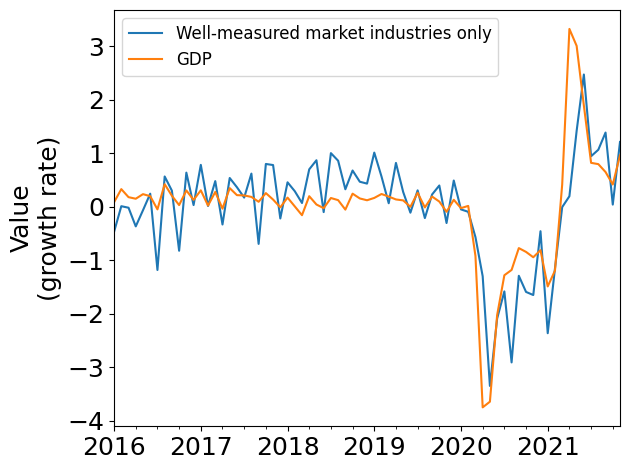

In [23]:
g_log_agg_season_short_df['Normalized_Value_g_Pay'].plot(label = 'Well-measured market industries only')
g_log_GDP_non_season_short_df['Normalized_Value_g_GDP'].plot(label = 'GDP')
plt.ylabel('Value\n(growth rate)',fontsize = 18)
plt.xticks(fontsize = 18)  # Rotate x-axis labels for better readability
plt.yticks(fontsize = 18)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.legend(fontsize = 12)
plt.savefig('plots/growth_rate_non_market_GDP.png',bbox_inches='tight')

plt.show()

## Filtering the growth rates <a id="defilter"></a>

To estimate cost-shares we need to group by 'to_pn'. For sales-shares we need to group by 'from_pn'.

In [24]:
# Filter to keep rows where both 'from_pn' and 'to_pn' are in the set aggregate_output_SIC5.index
df_filtered = df_amt[
    df_amt['from_pn'].isin(aggregate_output_SIC5.index) &
    df_amt['to_pn'].isin(aggregate_output_SIC5.index)]


In [25]:
def compute_industry_shares(df_amt,direction):
    if direction == 'to_pn':
        dir_2 = 'from_pn'
    else:
        dir_2 = 'to_pn'
    ### We filter out the industries that have zero total output
    df_int = df_amt[
        df_amt['from_pn'].isin(aggregate_output_SIC5.index) &
        df_amt['to_pn'].isin(aggregate_output_SIC5.index)]

    
    
    df_filtered = df_int.groupby(['from_pn','to_pn']).sum().reset_index()
    
    int_df1 = pd.merge(df_filtered[[direction]].set_index(direction), df_filtered.drop(columns = dir_2).groupby(direction).sum(), left_index=True, right_index=True, how='inner')
    industry_shares = pd.DataFrame(df_filtered.drop(columns = ['from_pn','to_pn']).values/int_df1.values)
    
    industry_shares.columns = df_filtered.drop(columns = ['from_pn','to_pn']).columns


    industry_shares['from_pn'] = df_filtered['from_pn']
    industry_shares['to_pn'] = df_filtered['to_pn']

    return industry_shares


In [26]:
inshare_matrix = compute_industry_shares(df_filtered,'to_pn')
outshare_matrix = compute_industry_shares(df_filtered,'from_pn')

In [27]:
adj_matrix = []
# Create the weighted adjacency matrix
for col in inshare_matrix.drop(columns = ['from_pn','to_pn']).T.loc['jan_amt_16':].T.columns:
    adj_matrix_int = inshare_matrix.pivot(index='from_pn', columns='to_pn', values=col)

    # Fill NaN values with 0, since missing edges imply a weight of 0
    adj_matrix.append(adj_matrix_int.fillna(0))

In [28]:
### Here we perform the filtereing procedure. I.e.e we filter out the growth rates.
alpha = 0.5
eps_idio_int  = []
for i,date in enumerate(g_log_SIC5):
    eps_idio_int.append((pd.DataFrame(np.eye(len(g_log_SIC5))).values - alpha*adj_matrix[i]).dot(g_log_SIC5[date]))
eps_idio = pd.concat(eps_idio_int, axis=1)
eps_idio.columns = g_log_SIC5.columns

# Factor Model Analysis <a id="factor-model"></a>

## Defining functions for loadings, factors and noise <a id="define-functions"></a>

In order to compute the common factor, the factor loadings and the idiosyncratic noise we 
1. demean our dataframe
2. standardize our dataframe
3. compute the common factor by specifying it to have an identity covariance.

Standardization means we divide each value in a given industry-row by the standard deviation of that row.

There is one issue in the function below. This becomes apparent for data with non-zero mean.

For r=1 (i.e. only the largest Eigenvalue kept) the dot-product of some panel data df (i.e. df.T $\cdot$ df) can be rescaled to be 1 (if scaled = True). However, the covariance matrix will not be one.

In [29]:
def demean(dataframe):
    # Calculate the mean across each row
    rw_means = dataframe.mean(axis=1)

    # Subtract the row mean from each element in the row
    df_substracted = dataframe.sub(rw_means, axis=0)
    
    return df_substracted, rw_means

In [30]:
def standardize(dataframe, demean = True):
    if demean == True:
        rw_means = dataframe.mean(axis=1)
        # Subtract the row mean from each element in the row
        dataframe = dataframe.sub(rw_means, axis=0)    
    else:
        pass
    dataframe = (dataframe.T/dataframe.T.std().values).T
    return dataframe

In [31]:
def sorted_eigenvalues(dataframe,r = 1, scaled = True, cov = True, demean = True):
    
        
    if demean == True:
        rw_means = dataframe.mean(axis=1)

        # Subtract the row mean from each element in the row
        dataframe = dataframe.sub(rw_means, axis=0)
    else:
        pass

    
    
    # Compute the matrix product eps_idio * eps_idio^
    if cov == True:
        df_array = dataframe.values
        matrix_product = np.cov(df_array) ## THIS PART IS POTENTIALLY CRITICAL: WE COULD ALSO COMPUTE THE DOT PRODUCT (for zero mean would be identical)
    else:
        df_array = (dataframe.T/dataframe.T.std().values).T.values
        matrix_product = np.corrcoef(df_array)
    
    # Compute the eigenvalues and eigenvectors of the matrix product
    eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

    # Sort the eigenvalues in descending order and get the indices of the r largest
    
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
    top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

    # Collect the corresponding eigenvectors
    top_r_eigenvectors = eigenvectors[:, top_r_indices]

    top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)

    
    top_r_eigenvalues = eigenvalues[ top_r_indices]
    top_r_eigenvalues_df = pd.DataFrame(top_r_eigenvalues)

    return top_r_eigenvalues_df, top_r_eigenvectors_df
    

In [32]:
def common_factor(dataframe, scaled = True, cov = True, demean = True):
    
    # r is the number of largest eigenvalues to keep
    r = 1
    
    if demean == True:
        rw_means = dataframe.mean(axis=1)

        # Subtract the row mean from each element in the row
        dataframe = dataframe.sub(rw_means, axis=0)
    else:
        pass

    
    
    # Compute the matrix product eps_idio * eps_idio^
    if cov == True:
        df_array = dataframe.values
        matrix_product = np.cov(df_array) ## THIS PART IS POTENTIALLY CRITICAL: WE COULD ALSO COMPUTE THE DOT PRODUCT (for zero mean would be identical)
    else:
        df_array = (dataframe.T/dataframe.T.std().values).T.values
        matrix_product = np.corrcoef(df_array)
    
    # Compute the eigenvalues and eigenvectors of the matrix product
    eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

    # Sort the eigenvalues in descending order and get the indices of the r largest
    
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
    top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

    # Collect the corresponding eigenvectors
    top_r_eigenvectors = eigenvectors[:, top_r_indices]

    top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)

    common_factor_df = top_r_eigenvectors_df.T.dot(df_array)

    ##### EVERYTHING IN THIS IF STATEMENT IS ABOUT RESCALING THE COMMON FACTOR TO HAVE AN IDENTITY COVARIANCE (i.e. to fix the f_t and consequently \lambda_i)
    if scaled == True:


        ##### This scaling follows the definition that 1/T \sum_t f_t f_t =1
        ##### Uncomment if this is preferred
        common_factor_df_scaled = common_factor_df / np.sqrt(common_factor_df.dot(common_factor_df.T)/len(common_factor_df.T)).values 


        ##### This scaling has a product that gives 1, i.e. \sum_t f_t f_t =1
        ##### Uncomment if this is preferred

        #common_factor_df_scaled = common_factor_df / np.sqrt(common_factor_df.dot(common_factor_df.T)).values 

        return common_factor_df_scaled
        

    else:
        return common_factor_df
    

In [33]:
def factor_loading(dataframe,  cov = True, demean = True):
    
    if demean == True:
        f_or_t_demean = True
        rw_means = dataframe.mean(axis=1)

        # Subtract the row mean from each element in the row
        dataframe = dataframe.sub(rw_means, axis=0)
    else:
        f_or_t_demean = False
        

    if cov == True:
        f_or_t = True
    else:
        f_or_t = False
        dataframe = (dataframe.T/dataframe.T.std().values).T
    common_factor_df = common_factor(dataframe,cov = f_or_t,demean = f_or_t_demean)
    # Prepare a list to store regression results
    regression_results = []

    # Perform regression for each column in Y against X
    for col in dataframe.T.columns:
        y = dataframe.T[col].values.reshape(-1, 1)
        model = LinearRegression()
        model.fit(common_factor_df.values.reshape(-1, 1), y)
        regression_results.append({
            'Time': col,
            'Intercept': model.intercept_[0],
            'Slope': model.coef_[0][0],
            'R_squared': model.score(common_factor_df.values.reshape(-1, 1), y)
        })

    # Convert the results to a DataFrame for better visualization
    factor_loading_df = pd.DataFrame(regression_results)
    
    return factor_loading_df

In [34]:
def common_product(dataframe,cov = True, demean = True):
    dataframe_orig = dataframe.copy()
    rw_means = dataframe.mean(axis=1)
    if demean == True:
        f_or_t_demean = True
        #rw_means = dataframe.mean(axis=1)

        # Subtract the row mean from each element in the row
        #dataframe = dataframe.sub(rw_means, axis=0)
    else:
        f_or_t_demean = False

    if cov == True:
        f_or_t = True
    else:
        f_or_t = False
        dataframe = (dataframe.T/dataframe.T.std().values).T
    common_factor_df = common_factor(dataframe, cov = f_or_t,demean = f_or_t_demean)
    factor_loading_df = factor_loading(dataframe, cov = f_or_t,demean = f_or_t_demean)

    
    common_df = pd.DataFrame(factor_loading_df['Slope'].values.reshape(-1, 1).dot(common_factor_df))
    common_df.columns = dataframe.columns

    
    # Below we decide whether the common factor needs to be rescaled to original units or not.
    if cov == True:
        if demean == False:
            return common_df
        else:
            ### This needs to be rechecked. If we are working with the demeaned data this will be are base data
            #return common_df.sub(-rw_means.values, axis=0) 
            return common_df

    elif cov == False:
        if demean == False:
            #return common_df

            return (common_df.T*dataframe_orig.T.std().values).T
        else:
            #return (common_df.sub(-rw_means.values, axis=0).T*dataframe_orig.T.std().values).T
            return (common_df.T*dataframe_orig.T.std().values).T

            
    #return common_df

In [35]:
def idio_shocks(dataframe, cov = True, demean = True):
    dataframe_orig = dataframe.copy()
    if demean == True:
        f_or_t_demean = True
        rw_means = dataframe.mean(axis=1)
        # Subtract the row mean from each element in the row
        #dataframe = dataframe.sub(rw_means, axis=0)
    else:
        f_or_t_demean = False
    
    if cov == True:
        f_or_t = True
        idio_shocks_df = dataframe - common_product(dataframe,cov = f_or_t, demean = f_or_t_demean).values

    else:
        f_or_t = False
        common_product_standard = (common_product(dataframe,cov = f_or_t, demean = f_or_t_demean).values.T/dataframe.T.std().values).T
        
        dataframe = (dataframe.T/dataframe.T.std().values).T
        idio_shocks_df = dataframe - common_product_standard
    
    
    # Below we decide whether the common factor needs to be rescaled to original units or not.
    if cov == True:
        return idio_shocks_df
    else:
        return (idio_shocks_df.T*dataframe_orig.T.std().values).T
    

# Contributions to aggregate growth <a id="agg-growth-cont"></a>

In order to perform the factor analysis we will have to demean either the 
- the filtered gowth rates
- the growth rates

## Defining relevant quantities

In [36]:
# Here we define the time-varying cost-shares matrix
adj_matrix = []
# Create the weighted adjacency matrix
for col in inshare_matrix.drop(columns = ['from_pn','to_pn']).T.loc['jan_amt_16':].T.columns:
    adj_matrix_int = inshare_matrix.pivot(index='from_pn', columns='to_pn', values=col)

    # Fill NaN values with 0, since missing edges imply a weight of 0
    adj_matrix.append(adj_matrix_int.fillna(0))

In [37]:
alpha = 0.5

The parameter alpha measures the closeness between the shocks and the growth rates. The larger alpha, the more weight we put on the network.

### Leontief inverse

In [38]:
L_matrix  = []

for i,date in enumerate(g_log_SIC5):
    L_matrix.append(pd.DataFrame(np.linalg.inv(pd.DataFrame(np.eye(len(g_log_SIC5))).values - alpha*adj_matrix[i])))

#### Aggregate growth of sales

In [39]:
g_log_agg_season = (outshares_SIC5.T.loc['2016-01-01':].T * g_log_SIC5).sum()


In [40]:
g_log_agg_season_demeaned = (outshares_SIC5.T.loc['2016-01-01':].T * demean(g_log_SIC5)[0]).sum()


In [41]:
g_log_agg_season_demeaned_static = (outshares_SIC5.T.mean().T @ demean(g_log_SIC5)[0])


In [42]:
g_log_agg_season_df = pd.DataFrame(g_log_agg_season)

mean_agg_seas = g_log_agg_season_df[0].mean()
std_agg_seas = g_log_agg_season_df[0].std()
g_log_agg_season_df['Normalized_Value_g_log'] = (g_log_agg_season_df[0] - mean_agg_seas) / std_agg_seas


We can decompose aggregate growth as 

\begin{align}
 g_{agg,t} = \sum_i \omega_{i,t}g_{i,t}
\end{align}
where $g_{i,t}$ can be further decomposed as
\begin{align}
 g_{i,t} = \sum_j L'_{ij} \Big(  \lambda_j f_t + \nu_{jt} \Big)
\end{align}
in order to obtain
\begin{align}
g_t = \sum_i w_i \sum_j L'_{ij} \Big(  \lambda_j f_t + \nu_{jt} \Big)
\end{align}

#### Defining the Leontief inverse

In [43]:
L_matrix  = []
for i,date in enumerate(g_log_SIC5):
    L_matrix.append(pd.DataFrame(np.linalg.inv(pd.DataFrame(np.eye(len(g_log_SIC5))).values - alpha*adj_matrix[i])))

In [44]:
## Here we reconstruct the 'raw'/non-demeaned growth rates
g_reconstructed_SIC5 = pd.DataFrame()
    
time = 0
for col in eps_idio.columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(eps_idio[col])))
    
    g_reconstructed_SIC5 = pd.concat([g_reconstructed_SIC5, new_col_df], axis=1)
    time = time + 1
g_reconstructed_SIC5.columns = g_log_SIC5.columns
g_reconstructed_SIC5.index = g_log_SIC5.index

In [45]:
## Here we reconstruct the 'raw'/non-demeaned growth rates
g_reconstructed_SIC5_demeaned = pd.DataFrame()
    
time = 0
for col in eps_idio.columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(demean(eps_idio)[0][col])))
    
    g_reconstructed_SIC5_demeaned = pd.concat([g_reconstructed_SIC5_demeaned, new_col_df], axis=1)
    time = time + 1
g_reconstructed_SIC5_demeaned.columns = g_log_SIC5.columns
g_reconstructed_SIC5_demeaned.index = g_log_SIC5.index

In [46]:
### If zero everything is correct
(g_log_SIC5 - g_reconstructed_SIC5).sum().sum()

-9.876075939718081e-15

#### Reconstructing aggregate growth

Here we test whether aggregate growth obtained as a weighted sum of industry-level growth rates matches with the reconstructed aggregate growth rate where we start with the filtered growht rates $\varepsilon$ as done above.

In [47]:
### Aggregateion of the non-demeaned unfitlered growth rates
g_log_agg_season_recons = (outshares_SIC5.T.loc['2016-01-01':].T * g_reconstructed_SIC5).sum()


In [48]:
### Aggregateion of the demeaned unfiltered growth rates
g_log_agg_season_recons_demeaned = (outshares_SIC5.T.loc['2016-01-01':].T * g_reconstructed_SIC5_demeaned).sum()


In [49]:
# Consistency check to see if reconstructe aggregate growth rate matches 
# aggregate growth rate computed from unfiltered growth rates
(g_log_agg_season_recons - g_log_agg_season).sum()

8.821068875342064e-16

## Decomposition shocks into common mode and noise (time-varying case)

In [50]:
# We compute eigenvalues of the covariance matrix not correlation matrix to estimate the factors.
# This parameter holds throughout the notebook.
cov = False

###### Computing common mode $\Lambda\cdot F^T$

In [51]:
common_eps_df = common_product(demean(eps_idio)[0],cov = cov, demean = False)

In [52]:
common_eps_df.columns = eps_idio.columns

###### Computing the idiosyncratic shocks

In [53]:
idio_shocks_eps_df = idio_shocks(demean(eps_idio)[0],cov = cov, demean = False)

#### Reconstructing common mode

Here, we compute the reconstructed common mode, i.e. after it has run through the network.

In [54]:
common_mode_reconstructed_SIC5 = pd.DataFrame()
    
time = 0
for col in common_eps_df.columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(common_eps_df[col])))
    
    common_mode_reconstructed_SIC5 = pd.concat([common_mode_reconstructed_SIC5, new_col_df], axis=1)
    time = time + 1
common_mode_reconstructed_SIC5.columns = g_log_SIC5.columns
common_mode_reconstructed_SIC5.index = g_log_SIC5.index

#### Reconstructing noise term

Here, we compute the reconstructed noise term, i.e. when run through the network.

In [55]:
idio_shocks_reconstructed_SIC5 = pd.DataFrame()
    
time = 0
for col in idio_shocks_eps_df.columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(idio_shocks_eps_df[col])))
    
    idio_shocks_reconstructed_SIC5 = pd.concat([idio_shocks_reconstructed_SIC5, new_col_df], axis=1)
    time = time + 1
idio_shocks_reconstructed_SIC5.columns = g_log_SIC5.columns
idio_shocks_reconstructed_SIC5.index = g_log_SIC5.index

#### Reconstructing aggregate common mode and aggregate idiosyncratic mode of $\varepsilon$ 

In [56]:
common_mode_agg_season_eps_recons = (outshares_SIC5.T.loc['2016-01-01':].T * common_mode_reconstructed_SIC5).sum()


In [57]:
idio_shock_agg_season_eps_recons = (outshares_SIC5.T.loc['2016-01-01':].T * idio_shocks_reconstructed_SIC5).sum()


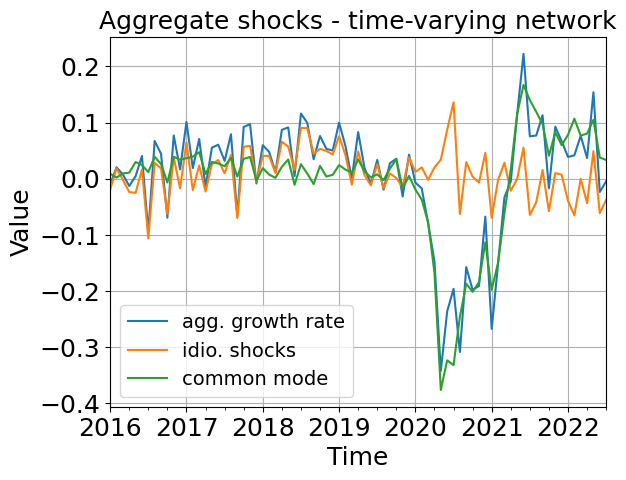

In [58]:
g_log_agg_season_recons_demeaned.plot(label = 'agg. growth rate')
idio_shock_agg_season_eps_recons.plot(label = 'idio. shocks')
common_mode_agg_season_eps_recons.plot(label = 'common mode')


plt.title('Aggregate shocks - time-varying network',fontsize = 18)

plt.xlabel('Time',fontsize = 18)
plt.ylabel('Value', fontsize = 18)
# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize = 14)

plt.grid(True)
plt.show()

## Decomposition shocks into common mode and noise (time-varying case, cross-sectional)

###### Computing common mode $\Lambda\cdot F^T$

In [59]:
common_factor_df_cs = demean(eps_idio)[0].mean()

In [60]:
regression_results = []
dataframe = demean(eps_idio)[0]
# Perform regression for each column in Y against X
for col in dataframe.T.columns:
    y = dataframe.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_cs.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_cs.values.reshape(-1, 1), y)
    })

factor_loading_df_cs = pd.DataFrame(regression_results)


In [61]:
common_eps_df_cs = pd.DataFrame(factor_loading_df_cs['Slope'].values.reshape(-1, 1).dot(common_factor_df_cs.values.reshape(1, -1)))
common_eps_df_cs.index = eps_idio.index
common_eps_df_cs.columns = eps_idio.columns

###### Computing the idiosyncratic shocks

In [62]:
idio_shocks_eps_df_cs = demean(eps_idio)[0]- common_eps_df_cs.values


#### Reconstructing common mode

Here, we compute the reconstructed common mode, i.e. after it has run through the network.

In [63]:
common_mode_reconstructed_SIC5_cs = pd.DataFrame()
    
time = 0
for col in common_eps_df.columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(common_eps_df_cs[col])))
    
    common_mode_reconstructed_SIC5_cs = pd.concat([common_mode_reconstructed_SIC5_cs, new_col_df], axis=1)
    time = time + 1
common_mode_reconstructed_SIC5_cs.columns = g_log_SIC5.columns
common_mode_reconstructed_SIC5_cs.index = g_log_SIC5.index

#### Reconstructing noise term

Here, we compute the reconstructed noise term, i.e. when run through the network.

In [64]:
idio_shocks_reconstructed_SIC5_cs = pd.DataFrame()
    
time = 0
for col in idio_shocks_eps_df_cs.columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(idio_shocks_eps_df_cs[col])))
    
    idio_shocks_reconstructed_SIC5_cs = pd.concat([idio_shocks_reconstructed_SIC5_cs, new_col_df], axis=1)
    time = time + 1
idio_shocks_reconstructed_SIC5_cs.columns = g_log_SIC5.columns
idio_shocks_reconstructed_SIC5_cs.index = g_log_SIC5.index

#### Reconstructing aggregate common mode and aggregate idiosyncratic mode of $\varepsilon$ 

In [65]:
common_mode_agg_season_eps_recons_cs = (outshares_SIC5.T.loc['2016-01-01':].T * common_mode_reconstructed_SIC5_cs).sum()


In [66]:
idio_shock_agg_season_eps_recons_cs = (outshares_SIC5.T.loc['2016-01-01':].T * idio_shocks_reconstructed_SIC5_cs).sum()


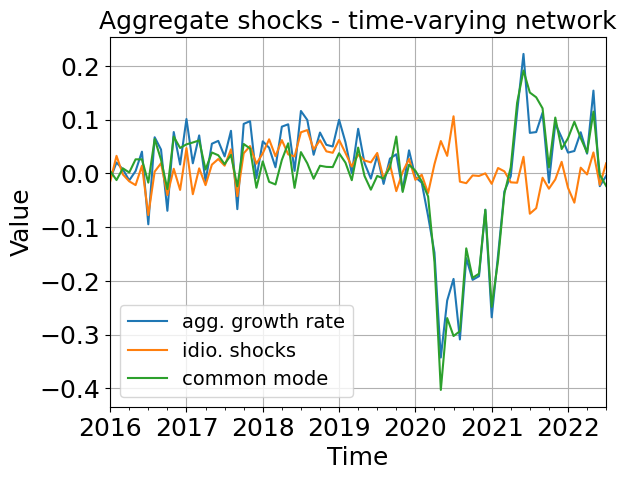

In [67]:
g_log_agg_season_recons_demeaned.plot(label = 'agg. growth rate')
idio_shock_agg_season_eps_recons_cs.plot(label = 'idio. shocks')
common_mode_agg_season_eps_recons_cs.plot(label = 'common mode')


plt.title('Aggregate shocks - time-varying network',fontsize = 18)

plt.xlabel('Time',fontsize = 18)
plt.ylabel('Value', fontsize = 18)
# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize = 14)

plt.grid(True)
plt.show()

## Decomposing demeaned unfiltered growth rates (time-varying case) <a id="unfiltered-cont-demeaned"></a>

Here, we could analyze either the growth rates obtained by propagating the demeaned shocks through the nextwork
or demean the growth rates right away.
The choice we take is to demean the growth rates, as this would correspond to the naive choice, which we are interested in inspecting here.

###### Computing $\Lambda\cdot F^T$

In [68]:
common_df = common_product(demean(g_log_SIC5)[0],cov = cov, demean = False)

In [69]:
common_df.columns = g_log_SIC5.columns
common_df.index = g_log_SIC5.index

###### Computing the idiosyncratic shocks

In [70]:
idio_shocks_g_df = idio_shocks(demean(g_log_SIC5)[0],cov = cov, demean = False)

###### Computing aggregate common and idiosyncratic modesx

In [71]:
common_mode_agg_season_recons = (outshares_SIC5.T.loc['2016-01-01':].T * common_df).sum()


In [72]:
idio_shock_agg_season_recons = (outshares_SIC5.T.loc['2016-01-01':].T * idio_shocks_g_df).sum()


###### Plotting the aggregate results of the factor model analysis

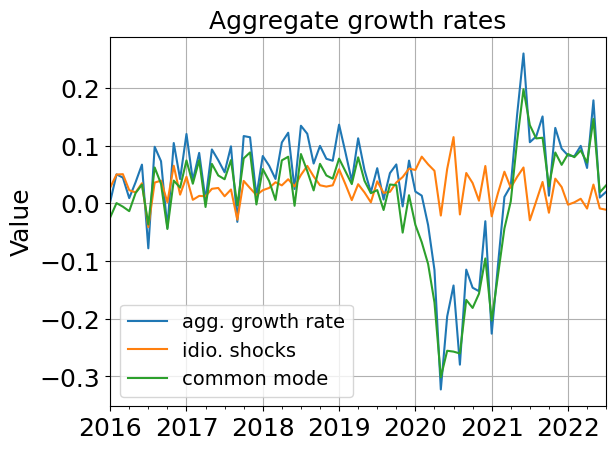

In [73]:
g_log_agg_season_demeaned.plot(label = 'agg. growth rate')
idio_shock_agg_season_recons.plot(label = 'idio. shocks')
common_mode_agg_season_recons.plot(label = 'common mode')

plt.title('Aggregate growth rates',fontsize = 18)
plt.ylabel('Value', fontsize = 18)
# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

## Decomposing demeaned unfiltered growth rates (time-varying case, cross-sectional average) <a id="unfiltered-cont-demeaned"></a>

Here, we could analyze either the growth rates obtained by propagating the demeaned shocks through the nextwork
or demean the growth rates right away.
The choice we take is to demean the growth rates, as this would correspond to the naive choice, which we are interested in inspecting here.

###### Computing common mode $\Lambda\cdot F^T$

In [74]:
common_factor_df_cs = demean(g_log_SIC5)[0].mean()

In [75]:
regression_results = []
dataframe = demean(g_log_SIC5)[0]
# Perform regression for each column in Y against X
for col in dataframe.T.columns:
    y = dataframe.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_cs.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_cs.values.reshape(-1, 1), y)
    })

factor_loading_df_cs = pd.DataFrame(regression_results)


In [76]:
common_g_df_cs = pd.DataFrame(factor_loading_df_cs['Slope'].values.reshape(-1, 1).dot(common_factor_df_cs.values.reshape(1, -1)))
common_g_df_cs.index = eps_idio.index
common_g_df_cs.columns = eps_idio.columns

###### Computing the idiosyncratic shocks

In [77]:
idio_shocks_g_df_cs = demean(g_log_SIC5)[0]- common_g_df_cs.values


###### Computing aggregate common and idiosyncratic modesx

In [78]:
common_mode_agg_season_recons_cs = (outshares_SIC5.T.loc['2016-01-01':].T * common_g_df_cs).sum()


In [79]:
idio_shock_agg_season_recons_cs = (outshares_SIC5.T.loc['2016-01-01':].T * idio_shocks_g_df_cs).sum()


###### Plotting the aggregate results of the factor model analysis

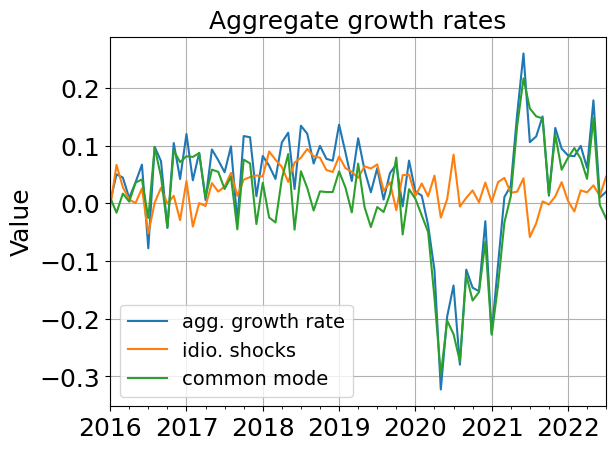

In [80]:
g_log_agg_season_demeaned.plot(label = 'agg. growth rate')
idio_shock_agg_season_recons_cs.plot(label = 'idio. shocks')
common_mode_agg_season_recons_cs.plot(label = 'common mode')

plt.title('Aggregate growth rates',fontsize = 18)
plt.ylabel('Value', fontsize = 18)
# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

### Growth rates and shocks (demeaned, time-varying) - Time-series

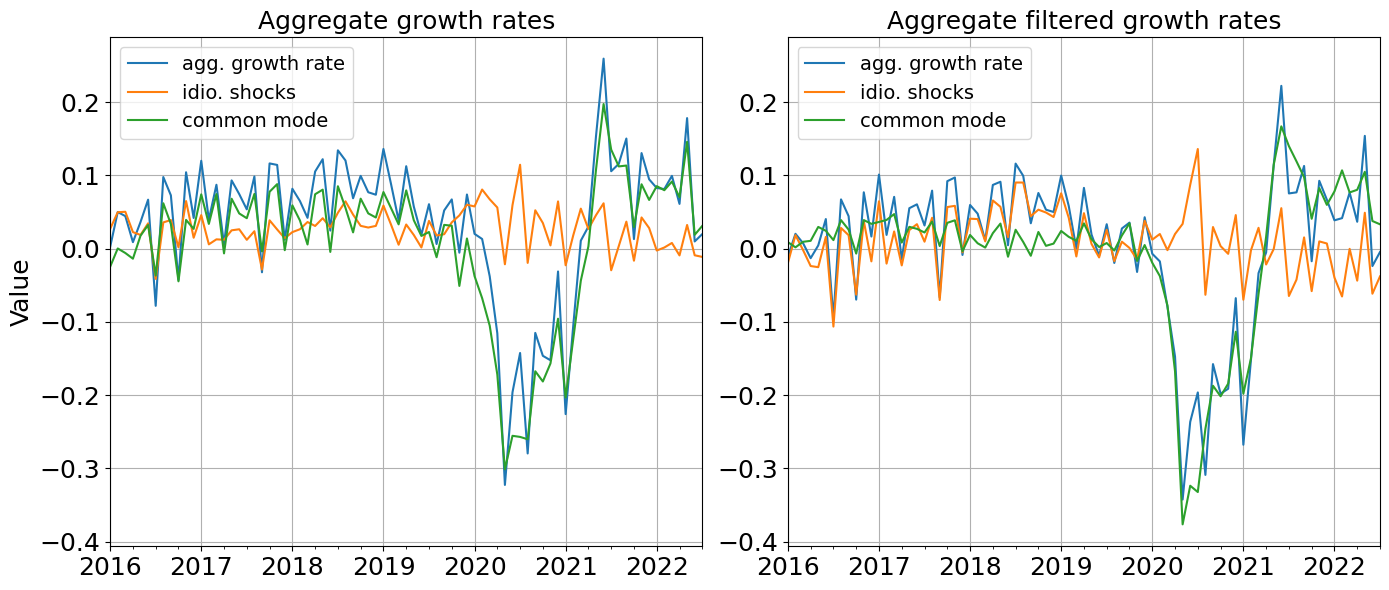

In [81]:
# Create a figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# First subplot
g_log_agg_season_recons_demeaned.plot(ax=ax[1], label='agg. growth rate')
idio_shock_agg_season_eps_recons.plot(ax=ax[1], label='idio. shocks')
common_mode_agg_season_eps_recons.plot(ax=ax[1], label='common mode')

ax[1].set_title('Aggregate filtered growth rates', fontsize=18)
ax[1].tick_params(axis='both', labelsize=18)
ax[1].legend(fontsize=14,loc='upper left')
ax[1].grid(True)

# Second subplot
g_log_agg_season_demeaned.plot(ax=ax[0], label='agg. growth rate')
idio_shock_agg_season_recons.plot(ax=ax[0], label='idio. shocks')
common_mode_agg_season_recons.plot(ax=ax[0], label='common mode')

ax[0].set_title('Aggregate growth rates', fontsize=18)
ax[0].set_ylabel('Value', fontsize=18)
ax[0].tick_params(axis='both', labelsize=18)
ax[0].legend(fontsize=14)
ax[0].grid(True)

# Set the y-axis range to be the same for both plots
y_min = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])
y_max = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])

ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('plots/decomposition_growth_and_shocks_demeaned_non_market_removed_time_var.png',bbox_inches='tight')
plt.show()

# Variance Analysis - from the top down

Here we provided an analysis of volatility of aggregate idiosyncratic shocks and aggregate common shocks.

## Entire sample

### Aggregate filtered growth rates (time-varying)

In [82]:
common_mode_agg_season_eps_recons_var = 100*common_mode_agg_season_eps_recons.T.std()**2

In [83]:
idio_shock_agg_season_eps_recons_var = 100*idio_shock_agg_season_eps_recons.T.std()**2

In [84]:
g_log_agg_season_recons_demeaned_var = 100*g_log_agg_season_recons_demeaned.std()**2

In [85]:
# Define the numerical variables
agg_var = g_log_agg_season_recons_demeaned_var
common_mode_var = common_mode_agg_season_eps_recons_var
idio_noise_var = idio_shock_agg_season_eps_recons_var

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} \\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 1.07 & 1.03 & 0.19 \\ \hline
\end{array}



### Aggregate growth rates (time-varying)

In [86]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_demeaned.var()
common_mode_var = 100*common_mode_agg_season_recons.var()
idio_noise_var = 100*idio_shock_agg_season_recons.var()

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate growth rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} \\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lccc}
\hline
\textbf{Volatility} & \textbf{Aggregate growth rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 1.02 & 0.97 & 0.08 \\ \hline
\end{array}



## pre-Covid period

We compute contributions to volatility for the pre-Covid period. There is a naive way of doing it which consists of just truncating the common mode and idiosyncratic mode that has been computed over the entire sample
We re-compute the common mode and the idiosycrantic mode based on the pre-Covid data only.

In [87]:
all_dates = eps_idio.columns[:]
pre_covid_dates = eps_idio.columns[0:49]
covid_dates = eps_idio.columns[49:]

### Naive pre-Covid: Aggregate growth rates (time-varying)

In [88]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_demeaned[pre_covid_dates].var()
common_mode_var = 100*common_mode_agg_season_recons[pre_covid_dates].var()
idio_noise_var = 100*idio_shock_agg_season_recons[pre_covid_dates].var()
cov_term = 2*100*np.cov(idio_shock_agg_season_recons[pre_covid_dates],common_mode_agg_season_recons[pre_covid_dates])[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}& \textbf{{Cov.}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f}\\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}& \textbf{Cov.} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 0.22 & 0.14 & 0.04 & 0.04\\ \hline
\end{array}



### Naive pre-Covid: Aggregate filtered growth rates (time-varying)

In [89]:
common_mode_agg_season_eps_recons_var = 100*common_mode_agg_season_eps_recons[pre_covid_dates].T.std()**2

In [90]:
idio_shock_agg_season_eps_recons_var = 100*idio_shock_agg_season_eps_recons[pre_covid_dates].T.std()**2

In [91]:
g_log_agg_season_recons_demeaned_var = 100*g_log_agg_season_recons_demeaned[pre_covid_dates].std()**2

In [92]:
# Define the numerical variables
agg_var = g_log_agg_season_recons_demeaned_var
common_mode_var = common_mode_agg_season_eps_recons_var
idio_noise_var = idio_shock_agg_season_eps_recons_var
cov_term = 2*100*np.cov(idio_shock_agg_season_eps_recons[pre_covid_dates],common_mode_agg_season_eps_recons[pre_covid_dates])[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}& \textbf{{Cov.}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f}\\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}& \textbf{Cov.} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 0.23 & 0.03 & 0.16 & 0.04\\ \hline
\end{array}



### Better estimate: Growth rates (pre-Covid)

Rather than truncating the common mode that has been computed for the entire sample period we compute the common mode for the pre-Covid (Covid) period only.

###### Computing $\Lambda\cdot F^T$

In [93]:
common_pre_cov_df = common_product(demean(g_log_SIC5[pre_covid_dates])[0],cov = cov, demean = False)

In [94]:
common_pre_cov_df.columns = g_log_SIC5[pre_covid_dates].columns
common_pre_cov_df.index = g_log_SIC5[pre_covid_dates].index

###### Computing the idiosyncratic shocks

In [95]:
idio_shocks_g_pre_cov_df = idio_shocks(demean(g_log_SIC5[pre_covid_dates])[0],cov = cov, demean = False)

In [96]:
common_mode_agg_season_recons_pre_cov = (outshares_SIC5.T.loc[pre_covid_dates].T * common_pre_cov_df).sum()


In [97]:
idio_shock_agg_season_recons_pre_cov = (outshares_SIC5.T.loc[pre_covid_dates].T * idio_shocks_g_pre_cov_df).sum()


In [139]:
### Aggregateion of the demeaned filtered growth rates
g_log_agg_season_recons_demeaned_pre_cov = (outshares_SIC5.T.loc[pre_covid_dates].T * demean(g_log_SIC5[pre_covid_dates])[0]).sum()






In [141]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_recons_demeaned_pre_cov[pre_covid_dates].var()
common_mode_var = 100*common_mode_agg_season_recons_pre_cov.var()
idio_noise_var = 100*idio_shock_agg_season_recons_pre_cov.var()
cov_term = 100*2*np.cov(idio_shock_agg_season_recons_pre_cov,common_mode_agg_season_recons_pre_cov)[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}  & \textbf{{Cov.}}\\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f} \\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))



\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}  & \textbf{Cov.}\\ \hline \hline
\text{Covariance} \ (10^{-2})   & 0.22 & 0.03 & 0.19 & -0.00 \\ \hline
\end{array}



### Better estimate: Filtered growth rates (pre-Covid)

Rather than truncating the common mode that has been computed for the entire sample period we compute the common mode for the pre-Covid (Covid) period only.

#### Decomposition shocks into common mode and noise (time-varying case)

In [99]:
# We compute eigenvalues of the covariance matrix not correlation matrix to estimate the factors.
# This parameter holds throughout the notebook.
cov = False

###### Computing $\Lambda\cdot F^T$

In [100]:
common_eps_pre_cov_df = common_product(demean(eps_idio[pre_covid_dates])[0], cov = cov, demean = False)

In [101]:
common_eps_pre_cov_df.columns = eps_idio[pre_covid_dates].columns

###### Computing the idiosyncratic shocks

In [102]:
idio_shocks_eps_pre_cov_df = idio_shocks(demean(eps_idio[pre_covid_dates])[0],cov = cov, demean = False)

#### Reconstructing growth rates

In [103]:
## Here we reconstruct the 'raw'/non-demeaned growth rates
g_reconstructed_SIC5_demeaned_pre_cov = pd.DataFrame()
    
time = 0
for col in eps_idio[pre_covid_dates].columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(demean(eps_idio[pre_covid_dates])[0][col])))
    
    g_reconstructed_SIC5_demeaned_pre_cov = pd.concat([g_reconstructed_SIC5_demeaned_pre_cov, new_col_df], axis=1)
    time = time + 1
g_reconstructed_SIC5_demeaned_pre_cov.columns = g_log_SIC5[pre_covid_dates].columns
g_reconstructed_SIC5_demeaned_pre_cov.index = g_log_SIC5[pre_covid_dates].index

#### Reconstructing common mode

In [104]:
common_mode_reconstructed_SIC5_pre_cov = pd.DataFrame()
    
time = 0
for col in common_eps_df[pre_covid_dates].columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(common_eps_pre_cov_df[col])))
    
    common_mode_reconstructed_SIC5_pre_cov = pd.concat([common_mode_reconstructed_SIC5_pre_cov, new_col_df], axis=1)
    time = time + 1
common_mode_reconstructed_SIC5_pre_cov.columns = g_log_SIC5[pre_covid_dates].columns
common_mode_reconstructed_SIC5_pre_cov.index = g_log_SIC5[pre_covid_dates].index

#### Reconstructing noise term

Here, we compute the reconstructed noise term, i.e. when run through the network.

In [105]:
idio_shocks_reconstructed_SIC5_pre_cov = pd.DataFrame()
    
time = 0
for col in idio_shocks_eps_pre_cov_df[pre_covid_dates].columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(idio_shocks_eps_pre_cov_df[col])))
    
    idio_shocks_reconstructed_SIC5_pre_cov = pd.concat([idio_shocks_reconstructed_SIC5_pre_cov, new_col_df], axis=1)
    time = time + 1
idio_shocks_reconstructed_SIC5_pre_cov.columns = g_log_SIC5[pre_covid_dates].columns
idio_shocks_reconstructed_SIC5_pre_cov.index = g_log_SIC5[pre_covid_dates].index

#### Reconstructing aggregate growth

In [106]:
common_mode_agg_season_eps_recons_pre_cov = (outshares_SIC5.T.loc[pre_covid_dates].T * common_mode_reconstructed_SIC5_pre_cov).sum()


In [107]:
idio_shock_agg_season_eps_recons_pre_cov = (outshares_SIC5.T.loc[pre_covid_dates].T * idio_shocks_reconstructed_SIC5_pre_cov).sum()


In [108]:
### Aggregateion of the demeaned unfiltered growth rates
g_log_agg_season_recons_demeaned_pre_cov = (outshares_SIC5.T.loc[pre_covid_dates].T * g_reconstructed_SIC5_demeaned_pre_cov).sum()


In [109]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_recons_demeaned_pre_cov[pre_covid_dates].var()
common_mode_var = 100*common_mode_agg_season_eps_recons_pre_cov.var()
idio_noise_var = 100*idio_shock_agg_season_eps_recons_pre_cov.var()
cov_term = 100*2*np.cov(idio_shock_agg_season_eps_recons_pre_cov,common_mode_agg_season_eps_recons_pre_cov)[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}  & \textbf{{Cov.}}\\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f} \\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))



\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}  & \textbf{Cov.}\\ \hline \hline
\text{Covariance} \ (10^{-2})   & 0.23 & 0.01 & 0.23 & -0.01 \\ \hline
\end{array}



### pre-Covid analysis - cross-sectional average

###### Computing common mode $\Lambda\cdot F^T$

In [110]:
common_factor_df_cs = demean(g_log_SIC5[pre_covid_dates])[0].mean()

In [111]:
regression_results = []
dataframe = demean(g_log_SIC5[pre_covid_dates])[0]
# Perform regression for each column in Y against X
for col in dataframe.T.columns:
    y = dataframe.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_cs.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_cs.values.reshape(-1, 1), y)
    })

factor_loading_df_cs = pd.DataFrame(regression_results)


In [112]:
common_g_df_cs_pre_cov = pd.DataFrame(factor_loading_df_cs['Slope'].values.reshape(-1, 1).dot(common_factor_df_cs.values.reshape(1, -1)))
common_g_df_cs_pre_cov.index = eps_idio[pre_covid_dates].index
common_g_df_cs_pre_cov.columns = eps_idio[pre_covid_dates].columns

###### Computing the idiosyncratic shocks

In [113]:
idio_shocks_g_df_cs_pre_cov = demean(g_log_SIC5[pre_covid_dates])[0]- common_g_df_cs_pre_cov.values


###### Computing aggregate common and idiosyncratic modesx

In [114]:
common_mode_agg_season_recons_cs_pre_covid  = (outshares_SIC5.T.loc[pre_covid_dates].T * common_g_df_cs).sum()


In [115]:
idio_shock_agg_season_recons_cs_pre_covid  = (outshares_SIC5.T.loc[pre_covid_dates].T * idio_shocks_g_df_cs).sum()


In [116]:
g_log_agg_season_demeaned_pre_covid = (outshares_SIC5.T.loc[pre_covid_dates].T * demean(g_log_SIC5[pre_covid_dates])[0]).sum()


In [117]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_demeaned_pre_covid[pre_covid_dates].var()
common_mode_var = 100*common_mode_agg_season_recons_cs_pre_covid[pre_covid_dates].var()
idio_noise_var = 100*idio_shock_agg_season_recons_cs_pre_covid[pre_covid_dates].var()
cov_term = 2*100*np.cov(idio_shock_agg_season_recons_cs_pre_covid[pre_covid_dates],common_mode_agg_season_recons_cs_pre_covid[pre_covid_dates])[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}& \textbf{{Cov.}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f}\\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}& \textbf{Cov.} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 0.22 & 0.18 & 0.12 & -0.07\\ \hline
\end{array}



## Covid period

### Naive Covid: Aggregate growth rates (time-varying)

In [118]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_demeaned[covid_dates].var()
common_mode_var = 100*common_mode_agg_season_recons[covid_dates].var()
idio_noise_var = 100*idio_shock_agg_season_recons[covid_dates].var()
cov_term = 2*100*np.cov(idio_shock_agg_season_recons[covid_dates],common_mode_agg_season_recons[covid_dates])[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}& \textbf{{Cov.}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f}\\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}& \textbf{Cov.} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 2.07 & 2.11 & 0.13 & -0.17\\ \hline
\end{array}



### Naive Covid: Aggregate filtered growth rates (time-varying)

In [119]:
common_mode_agg_season_eps_recons_var = 100*common_mode_agg_season_eps_recons[covid_dates].T.std()**2

In [120]:
idio_shock_agg_season_eps_recons_var = 100*idio_shock_agg_season_eps_recons[covid_dates].T.std()**2

In [121]:
g_log_agg_season_recons_demeaned_var = 100*g_log_agg_season_recons_demeaned[covid_dates].std()**2

In [122]:
# Define the numerical variables
agg_var = g_log_agg_season_recons_demeaned_var
common_mode_var = common_mode_agg_season_eps_recons_var
idio_noise_var = idio_shock_agg_season_eps_recons_var
cov_term = 2*100*np.cov(idio_shock_agg_season_eps_recons[covid_dates],common_mode_agg_season_eps_recons[covid_dates])[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}& \textbf{{Cov.}} \\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f}\\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))





\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}& \textbf{Cov.} \\ \hline \hline
\text{Covariance} \ (10^{-2})   & 2.11 & 2.50 & 0.24 & -0.63\\ \hline
\end{array}



### Better estimate: Growth rates

The better estimate involves recomputing the common and idiosyncratic modes from the period of interest.

###### Computing $\Lambda\cdot F^T$

In [142]:
common_cov_df = common_product(demean(g_log_SIC5[covid_dates])[0], cov = cov, demean = False)

In [143]:
common_cov_df.columns = g_log_SIC5[covid_dates].columns
common_cov_df.index = g_log_SIC5[covid_dates].index

###### Computing the idiosyncratic shocks

In [144]:
idio_shocks_g_cov_df = idio_shocks(demean(g_log_SIC5[covid_dates])[0],cov = cov, demean = False)

In [145]:
common_mode_agg_season_recons_cov = (outshares_SIC5.T.loc[covid_dates].T * common_cov_df).sum()


In [146]:
idio_shock_agg_season_recons_cov = (outshares_SIC5.T.loc[covid_dates].T * idio_shocks_g_cov_df).sum()


In [147]:
g_log_agg_season_demeaned_covid = (outshares_SIC5.T.loc['2016-01-01':].T * demean(g_log_SIC5[covid_dates])[0]).sum()


In [148]:
# Define the numerical variables
agg_var = 100*g_log_agg_season_demeaned_covid[covid_dates].var()
common_mode_var = 100*common_mode_agg_season_recons_cov.var()
idio_noise_var = 100*idio_shock_agg_season_recons_cov.var()
cov_term = 100*2*np.cov(idio_shock_agg_season_recons_cov,common_mode_agg_season_recons_cov)[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}  & \textbf{{Cov.}}\\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f} \\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))



\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}  & \textbf{Cov.}\\ \hline \hline
\text{Covariance} \ (10^{-2})   & 1.97 & 1.96 & 0.14 & -0.13 \\ \hline
\end{array}



### Better estimate: Filtered growth rates

Rather than truncating the common mode that has been computed for the entire sample period we compute the common mode for the pre-Covid (Covid) period only.

#### Decomposition shocks into common mode and noise (time-varying case)

In [168]:
# We compute eigenvalues of the covariance matrix not correlation matrix to estimate the factors.
# This parameter holds throughout the notebook.
cov = False

###### Computing $\Lambda\cdot F^T$

In [169]:
common_eps_cov_df = common_product(demean(eps_idio[covid_dates])[0],cov = cov, demean = False)

In [170]:
common_eps_cov_df.columns = eps_idio[covid_dates].columns

###### Computing the idiosyncratic shocks

In [171]:
idio_shocks_eps_cov_df = idio_shocks(demean(eps_idio[covid_dates])[0],cov = cov, demean = False)

#### Reconstructing growth rates

In [172]:
## Here we reconstruct the 'raw'/non-demeaned growth rates
g_reconstructed_SIC5_demeaned_cov = pd.DataFrame()
    
time = 0
for col in eps_idio[covid_dates].columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(demean(eps_idio[covid_dates])[0][col])))
    
    g_reconstructed_SIC5_demeaned_cov = pd.concat([g_reconstructed_SIC5_demeaned_cov, new_col_df], axis=1)
    time = time + 1
g_reconstructed_SIC5_demeaned_cov.columns = g_log_SIC5[covid_dates].columns
g_reconstructed_SIC5_demeaned_cov.index = g_log_SIC5[covid_dates].index

#### Reconstructing common mode

In [173]:
common_mode_reconstructed_SIC5_cov = pd.DataFrame()
    
time = len(pre_covid_dates)
for col in common_eps_df[covid_dates].columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(common_eps_cov_df
                                                         [col])))
    
    common_mode_reconstructed_SIC5_cov = pd.concat([common_mode_reconstructed_SIC5_cov, new_col_df], axis=1)
    time = time + 1
common_mode_reconstructed_SIC5_cov.columns = g_log_SIC5[covid_dates].columns
common_mode_reconstructed_SIC5_cov.index = g_log_SIC5[covid_dates].index

#### Reconstructing noise term

Here, we compute the reconstructed noise term, i.e. when run through the network.

In [174]:
idio_shocks_reconstructed_SIC5_cov = pd.DataFrame()
    
time = len(pre_covid_dates)
for col in idio_shocks_eps_df[covid_dates].columns:
    new_col_df = pd.DataFrame((L_matrix[time].values.dot(idio_shocks_eps_cov_df[col])))
    
    idio_shocks_reconstructed_SIC5_cov = pd.concat([idio_shocks_reconstructed_SIC5_cov, new_col_df], axis=1)
    time = time + 1
idio_shocks_reconstructed_SIC5_cov.columns = g_log_SIC5[covid_dates].columns
idio_shocks_reconstructed_SIC5_cov.index = g_log_SIC5[covid_dates].index

#### Reconstructing aggregate growth

In [177]:
### Aggregateion of the demeaned filtered growth rates
g_log_agg_season_recons_demeaned_cov = (outshares_SIC5.T.loc[covid_dates].T * demean(g_log_SIC5[covid_dates])[0]).sum()


In [178]:
common_mode_agg_season_eps_recons_cov = (outshares_SIC5.T.loc[covid_dates].T * common_mode_reconstructed_SIC5_cov).sum()


In [179]:
idio_shock_agg_season_eps_recons_cov = (outshares_SIC5.T.loc[covid_dates].T * idio_shocks_reconstructed_SIC5_cov).sum()


In [181]:
# Better estimate: Filtered growth rates
# Define the numerical variables
agg_var = 100*g_log_agg_season_recons_demeaned_cov[covid_dates].var()
common_mode_var = 100*common_mode_agg_season_eps_recons_cov.var()
idio_noise_var = 100*idio_shock_agg_season_eps_recons_cov.var()
cov_term = 100*2*np.cov(idio_shock_agg_season_eps_recons_cov,common_mode_agg_season_eps_recons_cov)[0,1]

# Create the LaTeX table with formatted numerical values
latex_table = rf"""

\begin{{array}}{{lcccc}}
\hline
\textbf{{Volatility}} & \textbf{{Aggregate shock rate (time-varying)}} & \textbf{{Common mode}} & \textbf{{Idiosyncratic shocks}}  & \textbf{{Cov.}}\\ \hline \hline
\text{{Covariance}} \ (10^{{-2}})   & {agg_var:.2f} & {common_mode_var:.2f} & {idio_noise_var:.2f} & {cov_term:.2f} \\ \hline
\end{{array}}

"""
# Display the table
display(Markdown(latex_table))



\begin{array}{lcccc}
\hline
\textbf{Volatility} & \textbf{Aggregate shock rate (time-varying)} & \textbf{Common mode} & \textbf{Idiosyncratic shocks}  & \textbf{Cov.}\\ \hline \hline
\text{Covariance} \ (10^{-2})   & 1.97 & 2.10 & 0.24 & -0.38 \\ \hline
\end{array}

